### Evolving Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

#### Imports, preparation, and creating the graphs

In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [4]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [5]:
#test function for unix time stamps to datetime
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [6]:
temp_nw.head(10)

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44
5,1,5,2002-08-01 23:04:48,2007-07-10 19:45:45
6,1,2,2002-08-01 23:04:48,2007-07-10 19:45:45
7,1,3,2006-06-06 12:47:15,2007-07-10 19:45:45
8,1,4,2002-08-01 23:04:48,2007-07-10 19:45:45
9,1,7,2002-08-01 23:04:48,2007-07-10 19:45:45


In [7]:
temp_nw.shape

(4729035, 4)

Let's create a timestamp for every two years: $T_i = $ 2002$+2i$-01-01 00:00:00.

In [8]:
# Create timestamps
dTime={}
for x in range(0,6):
    year = 2002 + 2 * x
    T = datetime.datetime(year, 1, 1, 0, 0, 0)
    dTime["T{0}".format(x)]=T
dTime

{'T0': datetime.datetime(2002, 1, 1, 0, 0),
 'T1': datetime.datetime(2004, 1, 1, 0, 0),
 'T2': datetime.datetime(2006, 1, 1, 0, 0),
 'T3': datetime.datetime(2008, 1, 1, 0, 0),
 'T4': datetime.datetime(2010, 1, 1, 0, 0),
 'T5': datetime.datetime(2012, 1, 1, 0, 0)}

Now that we have these timestamps, let's generate some graphs, $G_0, G_1, G_2, G_3, G_4$, each containing only the edges that appear between $T_i$ and $T_{i+1}$ for $G_i$.

In [9]:
# Create DataFrames for every timestamp
dfG={}
for x in range(0,5):
    T0 = "T{0}".format(x)
    T1 = "T{0}".format(x+1)
    T0 = dTime.get(T0)
    T1 = dTime.get(T1)
    df_G = temp_nw.copy()
    df_G = df_G[((df_G['start'] >= T0) & (df_G['start'] < T1)) | ((df_G['end'] > T0) & (df_G['end'] <= T1)) | 
                ((df_G['start'] < T0) & (df_G['end'] > T1))]
    dfG["df_G{0}".format(x)]=df_G
    print("df_G{0}".format(x) + ": " + str(df_G.shape))

df_G0: (217136, 4)
df_G1: (1246527, 4)
df_G2: (2520744, 4)
df_G3: (2083413, 4)
df_G4: (1107141, 4)


In [10]:
# Initialize a directed graph G from each of the given pandas dataframes.
dG={}
for x in range(0,5):
    G = "df_G{0}".format(x)
    G = dfG.get(G)
    G = nx.from_pandas_dataframe(G, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    dG["G{0}".format(x)]=G

Now we have a directed graph $G_1$ containing only the edges that were present at some point between $T_1 = $ 2002-01-01 00:00:00 and $T_2 = $ 2004-01-01 00:00:00.

Let's repeat these steps to generate some more graphs, $G_2, G_3, G_4, G_5$, each with only the edges that appear between $T_i$ and $T_{i+1}$ for $G_i$.

## The HITS algorithm
#### (Hyperlink-Induced Topic Search; also known as hubs and authorities)

Now that we have a graph for each of the time ranges, let's run the HITS algorithm on each of them.

In [17]:
# Run the HITS algorithm from networkx for each graph G.
# Returns two-tuple of dictionaries: (hubs, authorities).
dHITS={}
for x in range(0,5):
    G = "G{0}".format(x); G = dG.get(G)
    HITS = nx.hits(G, max_iter=200); print("HITS" + str(x) + " (" + str(2002+2*x) + " - " + str(2002+2*(x+1)) + 
                                          "): stored in dHITS(HITS" + str(x) + ")")
    dHITS["HITS{0}".format(x)]=HITS

HITS0 (2002 - 2004): stored in dHITS(HITS0)
HITS1 (2004 - 2006): stored in dHITS(HITS1)
HITS2 (2006 - 2008): stored in dHITS(HITS2)
HITS3 (2008 - 2010): stored in dHITS(HITS3)
HITS4 (2010 - 2012): stored in dHITS(HITS4)


Creating DataFrames with the hub- and authority-values:

In [19]:
# Creating DataFrames for hub and authority values
ddfHITS={}
for x in range(0,5):
    HITS = "HITS{0}".format(x); HITS = dHITS.get(HITS)
    hubs = HITS[0]; auth = HITS[1]
    df_hubs = pd.DataFrame.from_dict(hubs, orient='index')
    df_hubs.columns = ['Hub values']
    df_hubs['Node'] = df_hubs.index
    cols = df_hubs.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_hubs = df_hubs[cols]
    df_auth = pd.DataFrame.from_dict(auth, orient='index')
    df_auth.columns = ['Authority values']
    df_auth['Node'] = df_auth.index
    cols = df_auth.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_auth = df_auth[cols]
    df_HITS = pd.merge(df_hubs, df_auth, on='Node')
    ddfHITS["HITS{0}".format(x)] = df_HITS
    
# Example
ddfHITS.get("HITS0").head()

,Node,Hub values,Authority values
0,1,0.000057,0.000056
1,6,0.000000,0.000025
2,8,0.000000,0.000072
3,9,0.000840,0.001128
4,3,0.000060,0.000415


## Analysis
Now that we have dataframes containing the hub- and authority-values for each node, let's analyze them to see what differences or interesting attributes we can find.

We will start by looking at the top-3 best hubs and authorities for each time range.

In [29]:
# For each DataFrame, display the top-3 highest hub values
for x in range(0,5):
    df_HITS = "HITS{0}".format(x); df_HITS = ddfHITS.get(df_HITS)
    df_HITS = df_HITS.sort_values(by=['Hub values'], ascending=False)
    T = str(2002+2*x) + " - " + str(2002+2*(x+1)); print(T)
    display(df_HITS.head(3))

2002 - 2004


,Node,Hub values,Authority values
1689,103662,0.001945,0.000032
9016,5617,0.001477,0.000046
1435,126,0.001234,0.002010


2004 - 2006


,Node,Hub values,Authority values
34318,38845,0.000281,6.551914e-05
105109,45852,0.000279,1.166498e-07
136520,452457,0.000277,2.222430e-05


2006 - 2008


,Node,Hub values,Authority values
16898,9261,0.000384,5.272857e-08
8766,7540,0.000363,3.845687e-05
8767,7541,0.000360,6.292173e-05


2008 - 2010


,Node,Hub values,Authority values
14357,9261,0.000587,2.045553e-07
9619,18857,0.000511,3.182297e-05
127221,680980,0.000493,2.390078e-121


2010 - 2012


,Node,Hub values,Authority values
84577,680980,0.001091,7.628692e-109
1523,280,0.001083,1.470502e-04
87039,685436,0.001065,0.000000e+00


Immediately, we can see that the top-3 hub values are much higher for time the first DataFrame (2002 - 2004) than for the other DataFrames. Which is interesting, because this DataFrame contains far less edges than the others do.

Now, let's look at the top-3 authority values.

In [30]:
# For each DataFrame, display the top-3 highest authority values
for x in range(0,5):
    df_HITS = "HITS{0}".format(x); df_HITS = ddfHITS.get(df_HITS)
    df_HITS = df_HITS.sort_values(by=['Authority values'], ascending=False)
    T = str(2002+2*x) + " - " + str(2002+2*(x+1)); print(T)
    display(df_HITS.head(3))

2002 - 2004


,Node,Hub values,Authority values
5893,26251,0.000432,0.018541
6469,26254,0.000220,0.011855
317,394,0.000368,0.006929


2004 - 2006


,Node,Hub values,Authority values
13002,4088,2.834190e-08,0.035703
6883,9366,3.119819e-07,0.033025
12220,11726,8.656518e-09,0.029457


2006 - 2008


,Node,Hub values,Authority values
2563,300,0.000294,0.006312
382,241,0.000256,0.005949
2557,240,0.000191,0.005803


2008 - 2010


,Node,Hub values,Authority values
2199,300,0.000189,0.005409
2197,442,0.000245,0.005272
4701,241,0.000146,0.005071


2010 - 2012


,Node,Hub values,Authority values
4652,300,0.000013,0.004626
5694,442,0.000033,0.004518
4021,241,0.000017,0.004431


Again, we see that DataFrame 1 (2002 - 2004) has higher values than most other DataFrames. However, we can see that the authority values for DataFrame 2 (2004 - 2006) are much higher still. We would expect the hub- and authority-values to be more or less similar, because the hub-values are the sum of the connected authorities, and the authority-values are the sum of the connected hubs, the values are directly related. It's odd then, that for DataFrame 2 (2004 - 2006) the authority values are so much higher, while the hub-values were lower than the rest.

Let's create scatter plots like we did in task 1, to see if we can learn why this happens.

2002 - 2004


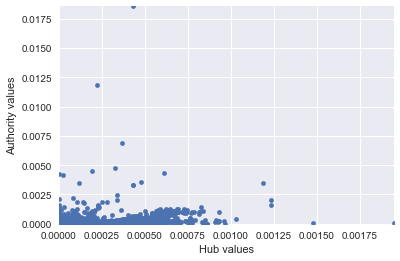

2004 - 2006


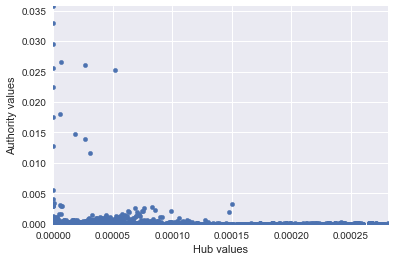

2006 - 2008


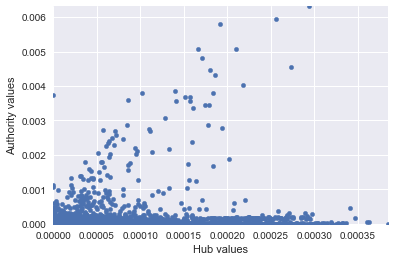

2008 - 2010


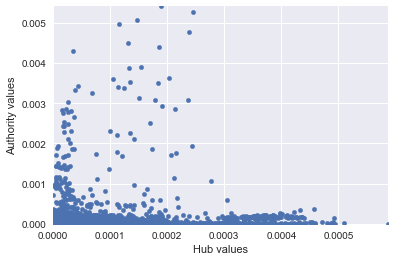

2010 - 2012


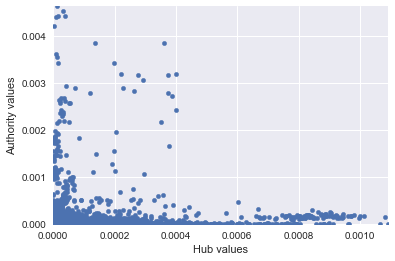

In [31]:
# Create a scatter plot for each DataFrame
for x in range(0,5):
    df_HITS = "HITS{0}".format(x); df_HITS = ddfHITS.get(df_HITS)
    T = str(2002+2*x) + " - " + str(2002+2*(x+1)); print(T)
    df_HITS.plot(kind='scatter', x='Hub values', y='Authority values', s=20);
    plt.xlim(0, df_HITS['Hub values'].max())
    plt.ylim(0, df_HITS['Authority values'].max())
    plt.show()

It is immediately obvious that there are very large differences between each of the plots. In plot #2 (2004 - 2006), which showed unexpectedly high authority values, we can see that the whole x-axis is filled with nodes that have no authority whatsoever, but that do have quite high hub-values. This explains why there are such high authority-values. Because there are so many hubs, if many of them link to a certain node, then obviously that node is going to have a very high authority.

Plot #3 (2006 - 2008) is most similar to the plot that we saw in task 1, where we ran the HITS algorithm on the complete static graph containing all edges. This is easily explained by the fact that this time range contains more edges than all the other time ranges (2520744/4729035). Having most of the edges of the original graph, it makes sense that the plot for this time range is closest to the original plot.

Plot #4 (2008 - 2010) and plot #5 (2010 - 2012) look very similar to each other. They look like the graph of an inverse power, with a few odd nodes scattered above said graph. They are mostly similar to the original plot, except that there appear to be far more strong authorities that aren't good hubs. The main observation that we had on the original plot was that there weren't any nodes that had a high authority without being decent hubs as well. For some reason, that appears to have changed in these last two time ranges. 

Plot #1 (2002 - 2004) is fairly boring, except for a couple of extreme outliers. This is probably caused by the fact that this time range has the least amount of edges (217136/4729035). A smaller sample size always means that there will be a higher chance for inconsistencies.